# Clustering

En este notebook estudiaremos cómo utilizar scikit-learn para aplicar los distintos algoritmos de clustering vistos en clase.

## Sobre random_state

En el código usaremos muchas funciones que incluyen cierta aleatoriedad. Estas funciones incluyen un parámetro llamado `random_state`. 

Si a `random_state` le asignamos un valor, estamos eliminando la aleatoriedad de esa función. De esta forma, los resultados de esa función serán reproducibles en ejecuciones posteriores.

Si quieres probar cómo cambia la ejecución por efecto de la aleatoriedad puedes eliminar `random_state` o cambiar el valor que se le asigna.

## Generación de los datos

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets.samples_generator import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Vamos a generar 500 puntos bidimensionales aleatorios usando 3 distribuciones Gaussianas distintas. Como cada distribución tiene un centro y una desviación típica distintas, los puntos quedarán concentrados en distintas zonas del plano.

In [3]:
# La función make_blobs permite generar puntos aleatorios siguiendo varias distribuciones Gaussianas. 
# Devuelve dos valores:
#  X contiene las coordenadas de los puntos generados
#  label números que indican la distribución que generó cada punto
real_centers = [[1, 1], [5, 5], [3, 11]]
stds = [1, 0.7, 1.7]
X, labels = make_blobs(n_samples = 500, centers = real_centers, cluster_std = stds, random_state=333)

print('Número de elementos:', len(X))
print('Primeros elementos de X:', X[0:10])
print('Primeras elementos de labels:', labels[0:10])

Número de elementos: 500
Primeros elementos de X: [[ 3.2641994  11.33392326]
 [ 1.06820348  2.14072039]
 [-0.86903879  1.61136546]
 [ 4.24281245  4.76892178]
 [ 1.83956164  9.34264327]
 [ 1.89182752 11.8053127 ]
 [ 0.50458842  0.3633292 ]
 [ 2.070033   14.59905921]
 [-0.20762619 -0.09493433]
 [ 0.32638429  1.36318608]]
Primeras elementos de labels: [2 0 0 1 2 2 0 2 0 0]


A continuación dibujamos los puntos en el plano. El color de cada punto indica la distribución a partir de la cual fue generado.

In [4]:
def plot_clusters(X, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """
    
    colors = ['r','g','b','c','y','k','m',]
    fig = plt.figure(figsize=(8,8))
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    plt.scatter(X[:,0], X[:,1], c=labels, cmap=ListedColormap(colors))
    
    # Pintar los centroides de los clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.show()

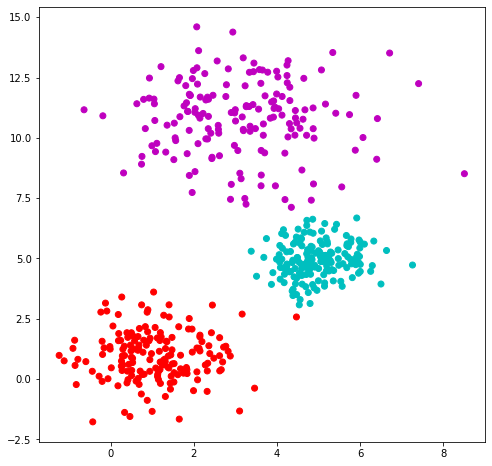

In [5]:
plot_clusters(X, labels)

Recuerda que los algoritmos de clustering se utilizan para encontrar patrones en datos no etiquetados. A partir de ahora "olvidaremos" la distribución que utilizamos para generar cada punto y trataremos de buscar distintas agrupaciones sólo a partir de sus coordenadas

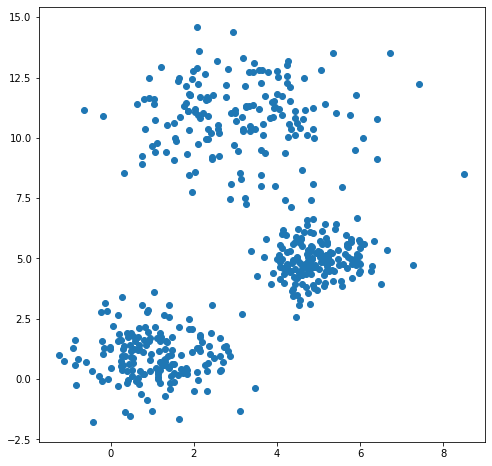

In [6]:
plot_clusters(X)

## Algoritmo k-Means

El algorithmo k-means agrupa los datos en K grupos disjuntos, minimizando la suma de distancias dentro de cada cluster. Recibe como parámetro el número de clusters que debe crear.

Descripción del algoritmo: https://scikit-learn.org/stable/modules/clustering.html#k-means

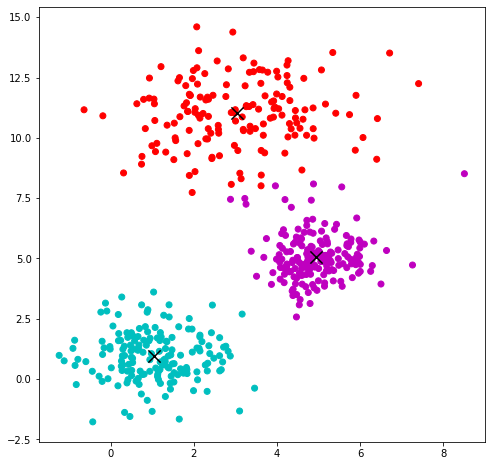

In [8]:
# Crear una instancia del agrupador k-means
km = KMeans(init='random', n_clusters=3, random_state=333)

# Agrupar los puntos en clusters
km.fit(X)

# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

plot_clusters(X, labels, centers)

Cuando usamos k-means tenemos que especificar el número de clusters que queremos crear y a veces no sabemos cuántas agrupaciones deberíamos crear. Una opción es realizar varias agrupaciones con distintos valores de K y estudiar cómo de homogéneos son los clusters resultantes. 

En el siguiente ejemplo generamos agrupaciones con valores de K entre 2 y 7, y estudiamos cómo aumenta el índice de Davies–Bouldin que se define como la razón entre las distancias intra-cluster y las distancias inter-cluster. Es decir, el índice tendrá un valor más pequeño cuando más compactos y separados estén los clusters.

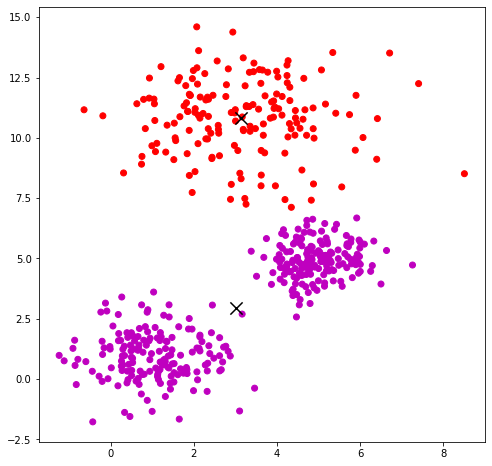

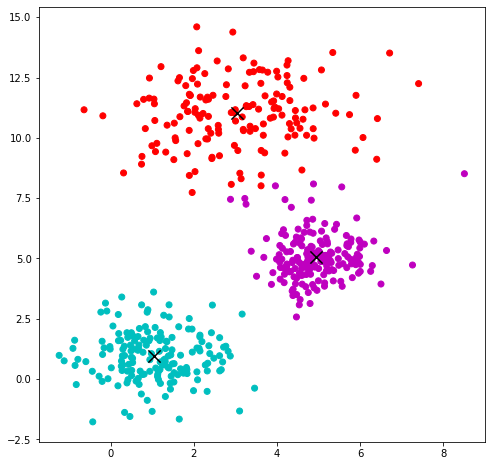

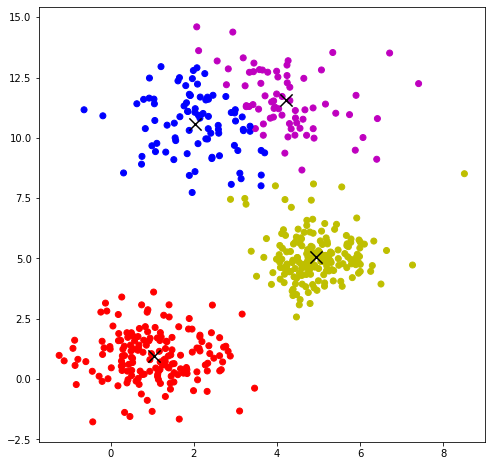

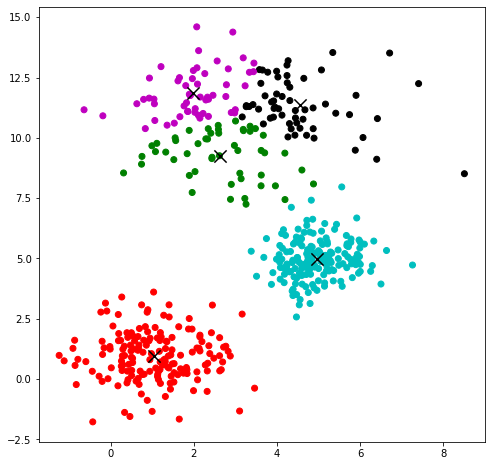

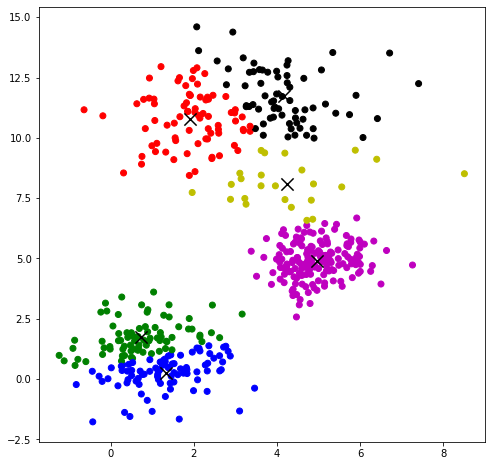

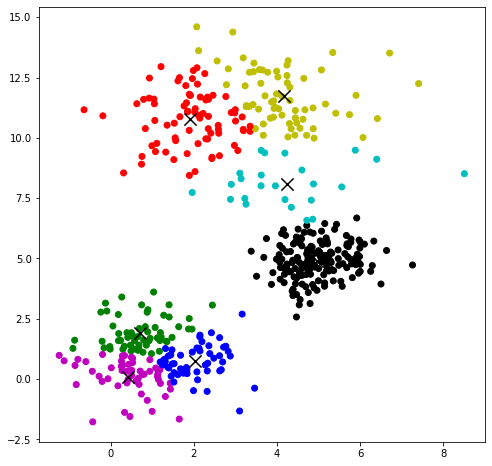

In [9]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(X)
    plot_clusters(X, km.labels_, km.cluster_centers_)
    
    davies_boulding[k-2] = davies_bouldin_score(X, km.labels_) 

A continuación pintamos el valor del índice de Davies–Bouldin para distintos valores de K. Podemos observar que el mejor valor (el más pequeño) se obtiene para k = 3 y es coherente porque generamos los datos a partir de 3 distribuciones distintas.

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

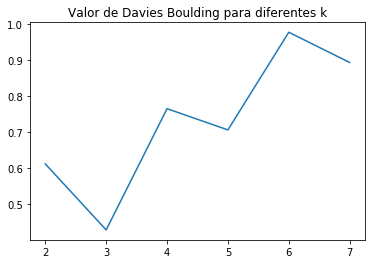

In [10]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

## Describiendo los clusters

En primer lugar, podemos ver fácilmente los centroídes elegidos, es decir, el valor que toman las variables en el individuo prototípico de cada cluster.

In [11]:

km = KMeans(init='random', n_clusters=3, random_state=333)
km.fit(X)


centers = km.cluster_centers_
centers

array([[ 3.0343045 , 11.02495403],
       [ 1.04817958,  0.96015374],
       [ 4.94551585,  5.07626246]])

También podemos segmentar los individuos de nuestro conjunto de datos según al cluster al que pertenezcan y utilizar estadísticos descriptivos para ver la distribución de las variables (centralidad, dispersión, rangos, etc).

Para ello crearemos un dataframe y le añadiremos la columna de los clusters

In [12]:
import pandas as pd

# 
df = pd.DataFrame(data=X, columns=['x','y'])
df = df.assign(cluster=pd.Series(data=km.labels_))
df

,x,y,cluster
0,3.264199,11.333923,0
1,1.068203,2.140720,1
2,-0.869039,1.611365,1
3,4.242812,4.768922,2
4,1.839562,9.342643,0
5,1.891828,11.805313,0
6,0.504588,0.363329,1
7,2.070033,14.599059,0
8,-0.207626,-0.094934,1
9,0.326384,1.363186,1


Podemos obtener una descripción buena directamente con pandas 

In [79]:

df.groupby(["cluster"]).describe()


0                                                              \
         count      mean       std       min       25%       50%       75%   
cluster                                                                      
0        156.0  3.034305  1.444775 -0.642767  1.982965  3.001385  4.001011   
1        166.0  1.048180  0.941888 -1.242285  0.411306  1.014429  1.631325   
2        178.0  4.945516  0.748637  2.882810  4.469431  4.854060  5.348234   

                       1                                                       \
              max  count       mean       std       min        25%        50%   
cluster                                                                         
0        7.411194  156.0  11.024954  1.352989  7.734154  10.171556  11.052476   
1        3.462953  166.0   0.960154  1.018752 -1.772167   0.326099   0.961067   
2        8.513899  178.0   5.076262  0.971870  2.575238   4.509967   4.952137   

                               
               75%        max  
cluster                        
0        11.773890  14.599059  
1         1.597640   3.607836  
2         5.569592   8.512722

Incluso visualizar la distribución de sus variable

cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: x, dtype: object

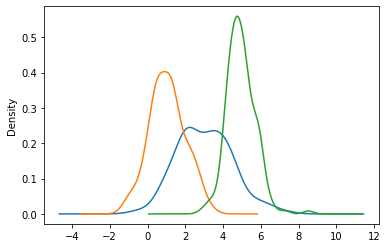

In [13]:
df.groupby(["cluster"])["x"].plot(kind="density")

cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: y, dtype: object

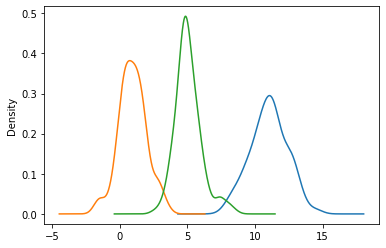

In [14]:
df.groupby(["cluster"])["y"].plot(kind="density")

## Cambio de escala y normalización

El algoritmo k-means es muy sensible al rango de las variables. Si una de las variables puede tomar valores mucho más grandes que otra, contribuirá mucho más a la distancia entre los puntos. Por ese motivo, suele ser una buena idea normalizar o estandarizar las variables antes de intentar agruparlas.

En el siguiente ejemplo vamos a multiplicar la primera coordenada de los puntos por 100 (esto podría suceder si una variable esta medida en metros y otra en centímetros) y comprobaremos el efecto que tiene al crear los clusters.

In [15]:
# Creamos una copia de los puntos para no modificar los originales
X2 = X.copy()
X2[:,0] = X2[:,0] * 100

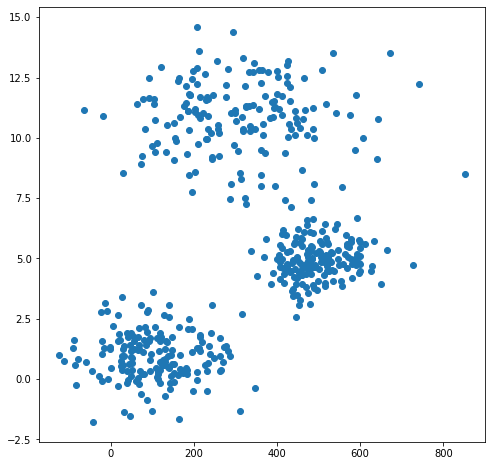

In [16]:
# Ahora los valores del eje horizontal son 100 veces mayores que antes
plot_clusters(X2)

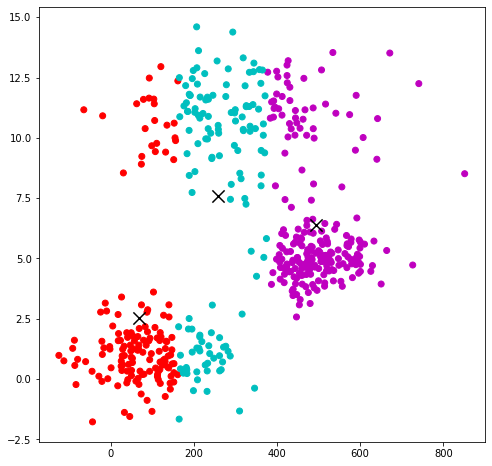

In [17]:
# Usamos k-means
km = KMeans(init='random', n_clusters=3, random_state=333)
km.fit(X2)
plot_clusters(X2, km.labels_, km.cluster_centers_)

En la gráfica anterior podemos comprobar que la división en clusters se ha hecho en función de la primera coordenada de cada punto (por eso son divisiones verticales). En este caso esa coordenada es 100 veces más importante que la otra a la hora de calcular las distancias.

Para evitar este tipo de comportamientos conviene normalizar o estandarizar los datos como hacemos en el ejemplo siguiente.

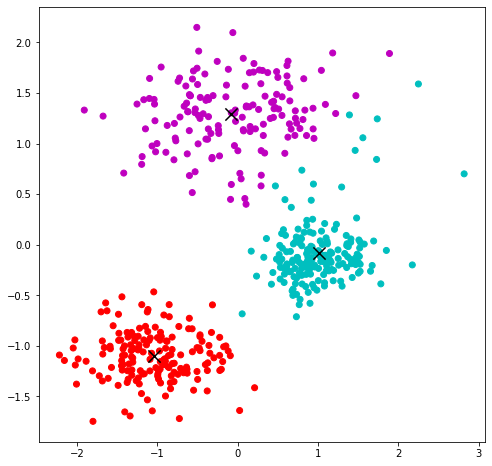

x                                                              \
         count      mean       std       min       25%       50%       75%   
cluster                                                                      
0        165.0  1.035362  0.930120 -1.242285  0.410129  0.996699  1.614541   
1        183.0  5.008968  0.759124  3.163068  4.481666  4.880890  5.475734   
2        152.0  2.895890  1.290778 -0.642767  1.963745  2.957707  3.884268   

                       y                                                       \
              max  count       mean       std       min        25%        50%   
cluster                                                                         
0        3.462953  165.0   0.949640  1.012780 -1.772167   0.324352   0.960278   
1        8.513899  183.0   5.220567  1.376083  2.575238   4.519362   4.963833   
2        6.713814  152.0  10.992097  1.430392  7.249678  10.171556  11.075656   

                               
               75%        max  
cluster                        
0         1.592408   3.607836  
1         5.602308  12.247019  
2        11.773890  14.599059

In [19]:
from sklearn.preprocessing import StandardScaler

# Normalizamos los datos para que estén centrados en 0 y con varianza 1
scaler = StandardScaler()
X3 = scaler.fit_transform(X2)

# Aplicamos ahora k-means
km = KMeans(init='random', n_clusters=3)
km.fit(X3)
plot_clusters(X3, km.labels_, km.cluster_centers_)

df2 = pd.DataFrame(data=X, columns=['x','y'])
df2 = df2.assign(cluster=pd.Series(data=km.labels_))

df2.groupby(["cluster"]).describe()

## Algoritmo jerárquico aglomerativo

Los algoritmos de agrupamiento jerárquico construyen clusters anidados uniendo o separando otros clusters. La jerarquía de clusters se puede representar en forma de árbol o dendrograma. Los algoritmos aglomerativos construyen los clusters de abajo hacia arriba: inicialmente cada punto es un cluster y se van uniendo para crear clusters más grandes.

Existen distintas estrategias de agrupamiento de clusters que se pueden consultar en la documentación: ward, complete linkage, average linkage o single linkage.

Descripción del algoritmo: https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

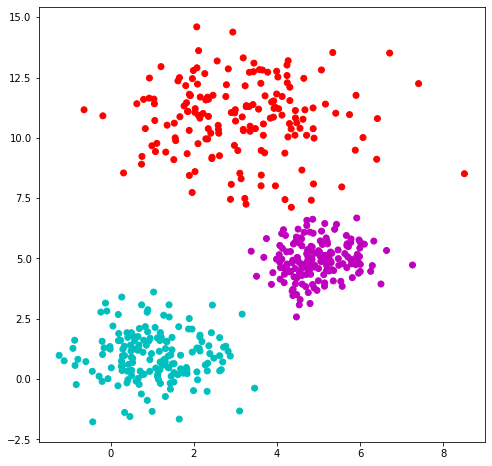

In [20]:
# Crear una instancia del agrupador jerárquico aglomerativo
ag = AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean')

# Agrupar los puntos en clusters
ag.fit(X)

# Podemos consultar el cluster asignado a cada punto
labels = ag.labels_

plot_clusters(X, labels)

Al igual que antes, vamos a estudiar como afecta el número de clusters generados al índice Davies-Bouldin que mide cómo de compactos y separados quedan los clusters.

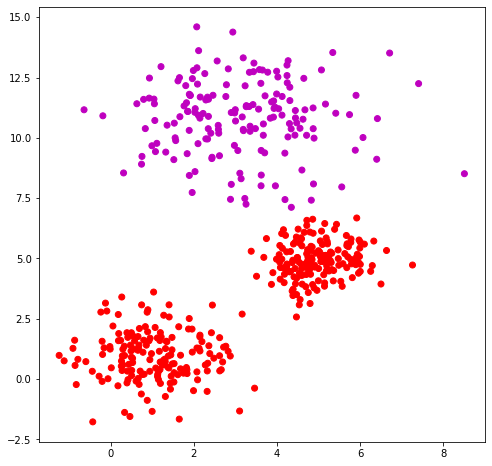

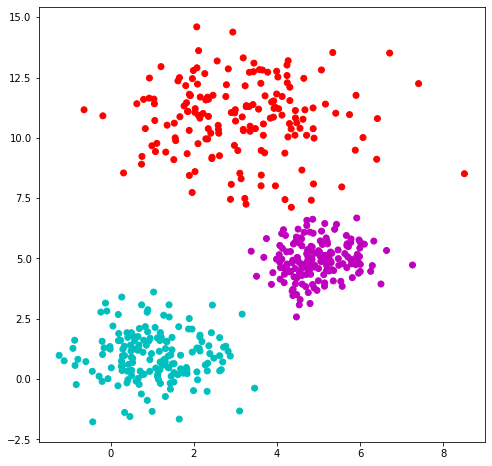

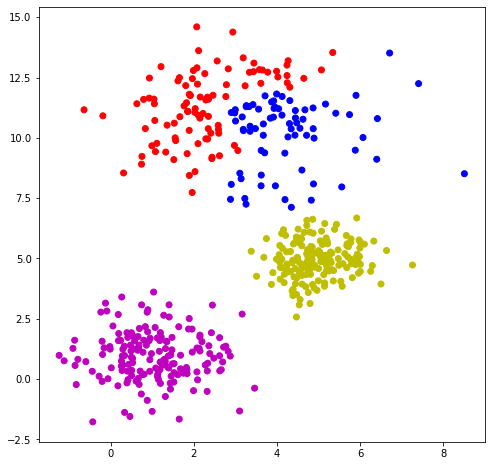

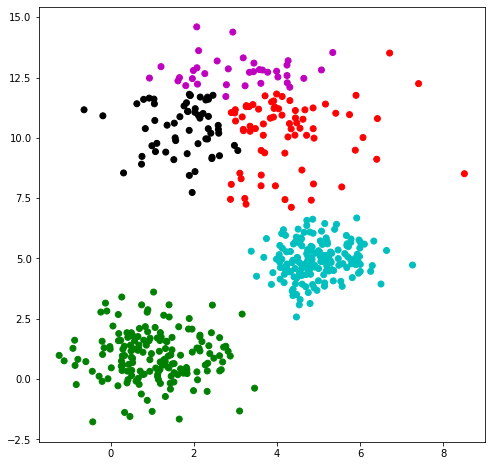

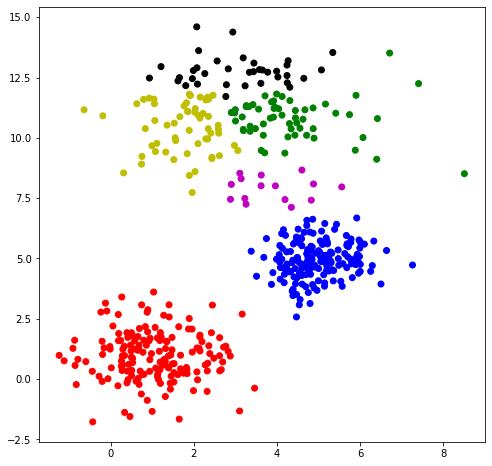

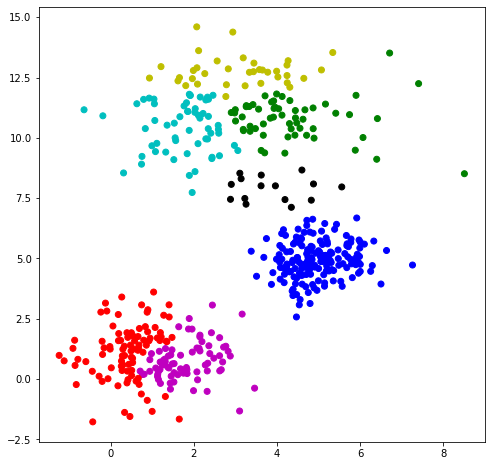

In [21]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
for k in range(2, K_MAX): 
    ag = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    ag.fit(X)
    plot_clusters(X, ag.labels_)
    
    davies_boulding[k-2] = davies_bouldin_score(X, ag.labels_) 

Text(0.5, 1.0, 'Valor de Davies Boulding para diferentes k')

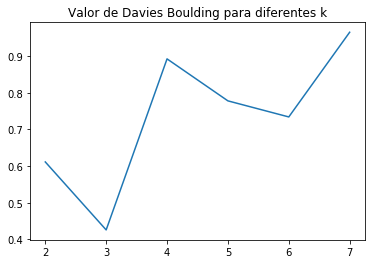

In [22]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')

Finalmente, vamos a dibujar el dendrograma de la jerarquía de clusters. El árbol completo es demasiado grande (tiene tantas hojas como puntos) así que nos limitaremos a dibujar sólo los primeros niveles del árbol.

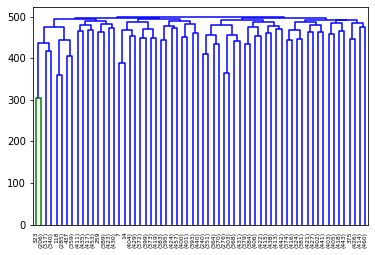

In [23]:
# Sciki-learn no pinta el dendrograma, pero scipy sí, 
# la siguiente función permite usar el modelo ajustado por scikit learn para pintar el dendrograma
# https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    


ag = AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean')
ag.fit(X)

# Dibujar los primeros 5 niveles del árbol
levels = 5
plot_dendrogram(ag, p=levels, truncate_mode='level')

# Árbol completo
#plot_dendrogram(ag)